In [32]:
# pip install seaborn

In [33]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv("SAML-D.csv")

In [36]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Time                    1048575 non-null  object 
 1   Date                    1048575 non-null  object 
 2   Sender_account          1048575 non-null  int64  
 3   Receiver_account        1048575 non-null  int64  
 4   Amount                  1048575 non-null  float64
 5   Payment_currency        1048575 non-null  object 
 6   Received_currency       1048575 non-null  object 
 7   Sender_bank_location    1048575 non-null  object 
 8   Receiver_bank_location  1048575 non-null  object 
 9   Payment_type            1048575 non-null  object 
 10  Is_laundering           1048575 non-null  int64  
 11  Laundering_type         1048575 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 96.0+ MB


In [37]:

transactions_per_payment_type = df['Payment_type'].value_counts()


laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 ACH                222636
 Credit card        222166
 Cheque             221939
 Debit card         221781
 Cross-border       101322
 Cash Withdrawal     33577
 Cash Deposit        25154
 Name: count, dtype: int64,
 Payment_type
 ACH                117
 Cash Deposit       130
 Cash Withdrawal    122
 Cheque             115
 Credit card        133
 Cross-border       229
 Debit card         110
 dtype: int64)

In [38]:
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])

normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])

print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     6.213932e+06
mean    3.657156e+04
min     2.477000e+01
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     999946.470000
mean      8682.218377
min          5.190000
Name: Amount, dtype: float64


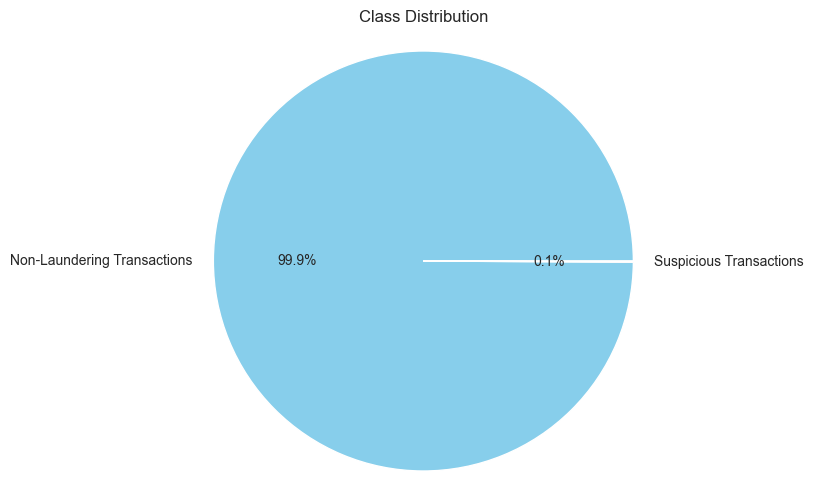

In [53]:
class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()

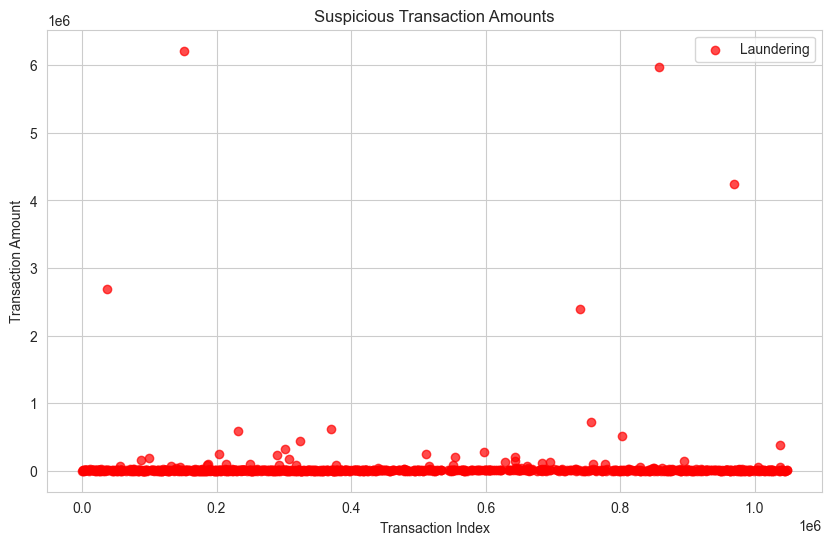

In [51]:
laundering_data = df[df['Is_laundering'] == 1]
non_laundering_data = df[df['Is_laundering'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(laundering_data.index, laundering_data['Amount'], color='red', label='Laundering', alpha=0.7)

plt.title('Suspicious Transaction Amounts')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Number of Alerts')

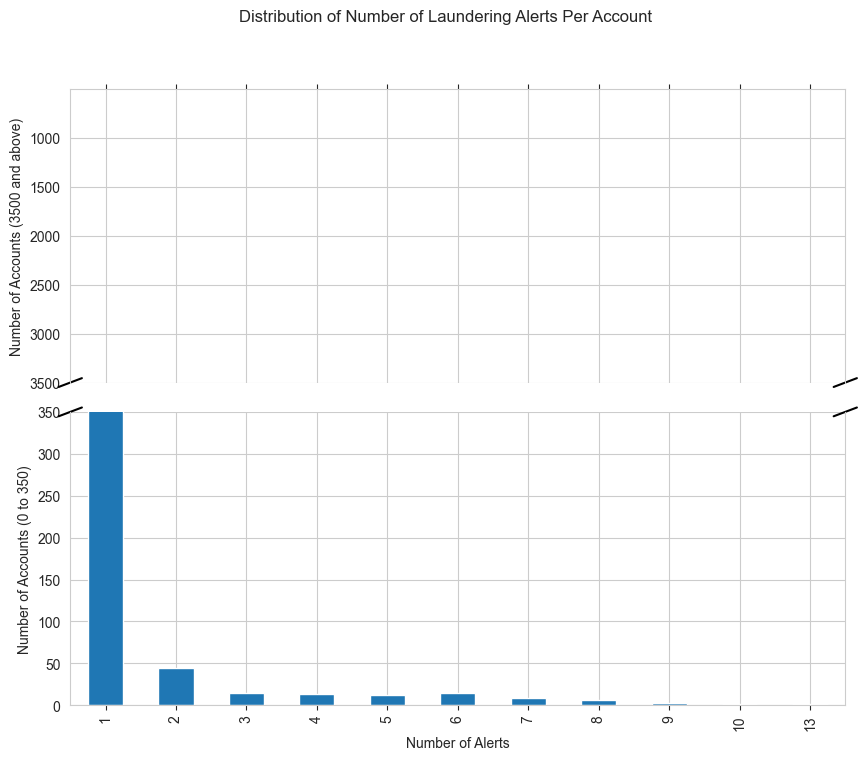

In [41]:
laundering_df = df[df['Is_laundering'] == 1]

account_alert_counts = laundering_df.groupby('Sender_account').size()
alert_distribution = account_alert_counts.value_counts()
alert_distribution = alert_distribution.sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
fig.subplots_adjust(hspace=0.1)

alert_distribution.plot(kind='bar', ax=ax1)
alert_distribution.plot(kind='bar', ax=ax2)

fig.suptitle('Distribution of Number of Laundering Alerts Per Account')

ax1.set_ylim(3500, alert_distribution.max()+50)
ax2.set_ylim(0, 350)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .015  # diagonal lines size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

ax2.set_ylabel('Number of Accounts (0 to 350)')
ax1.set_ylabel('Number of Accounts (3500 and above)')
ax2.set_xlabel('Number of Alerts')

Original Skewness: 53.46067770907625
Log-Transformed Skewness: -1.0106522237591442


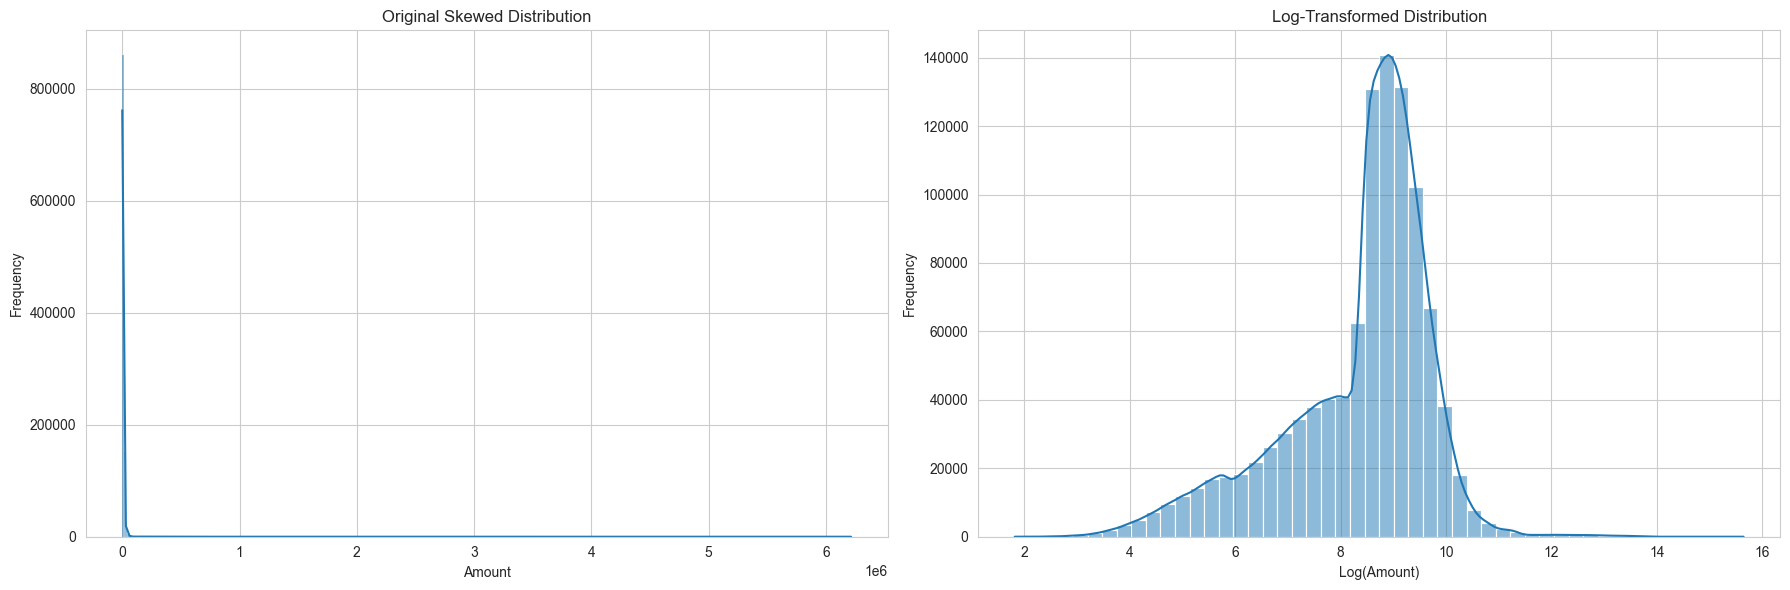

In [42]:
skewed_data = df['Amount']

original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

# Apply a log transformation
log_transformed_data = np.log1p(skewed_data)
# skewness after log transformation
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(skewed_data, bins=500, kde=True, ax=ax[0])
ax[0].set_title('Original Skewed Distribution')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(log_transformed_data, bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution')
ax[1].set_xlabel('Log(Amount)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [43]:
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot], how='outer')
combined_pivot = combined_pivot.fillna(0)

cm = sns.light_palette("blue", as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm)

styled_combined_pivot

/var/folders/1j/g0dbmj351815t2_1w_xl3jrm0000gn/T/ipykernel_2758/1828936050.py:1: FutureWarning: The provided callable <function sum at 0x10338bc10> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)


,Amount,Laundering_Count,Normal_Count
Payment_type,,,
ACH,2002210134.634332,117,222519
Cash Deposit,54275822.010000,130,25024
Cash Withdrawal,5177920.840000,122,33455
Cheque,2017822215.628851,115,221824
Credit card,1997301064.447282,133,222033
Cross-border,1014681575.101712,229,101093
Debit card,2039150615.884231,110,221671


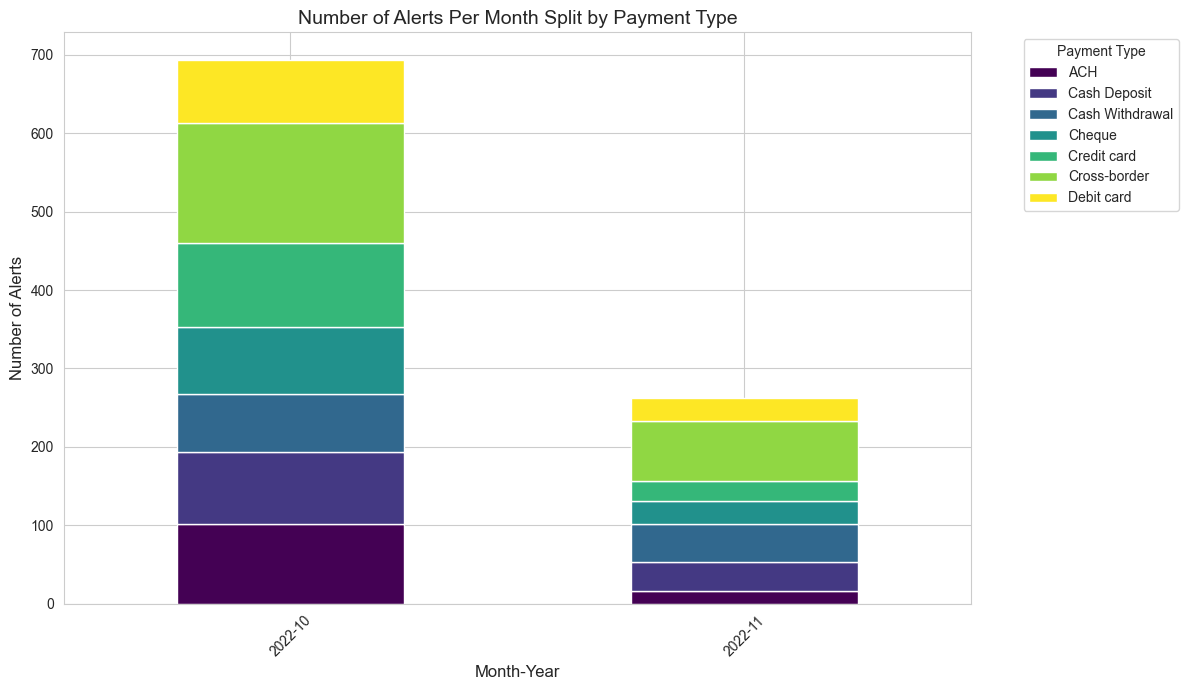

In [44]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
grouped_data = df.groupby(['Date', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()
grouped_data['Month_Year'] = grouped_data['Date'].dt.to_period('M')
monthly_alerts = grouped_data.groupby(['Month_Year', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()

pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
pivot_data.plot(kind='bar', ax=ax, stacked=True, colormap='viridis')
pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

plt.title('Number of Alerts Per Month Split by Payment Type', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Alerts', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

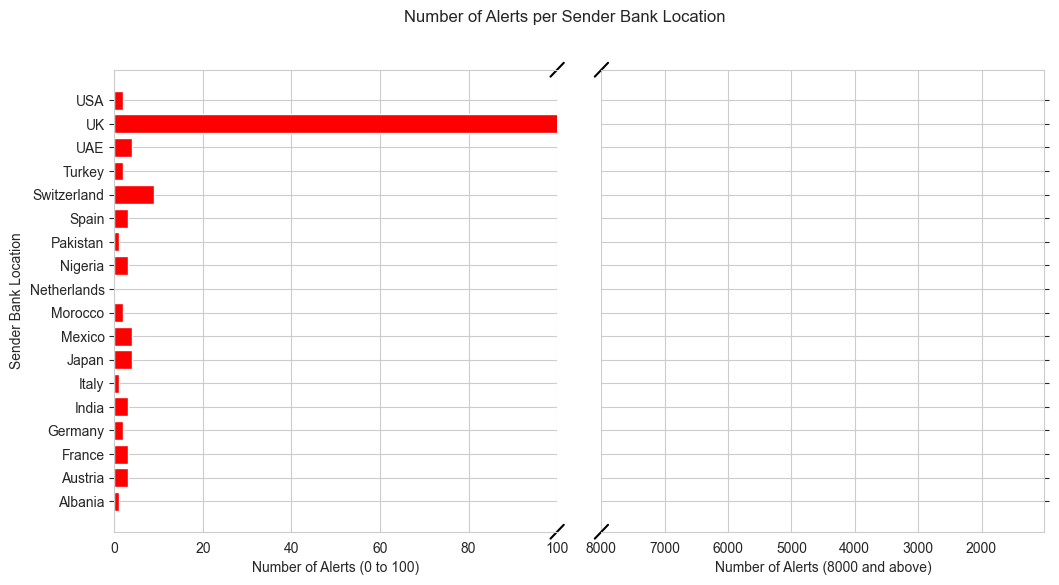

In [45]:
alerts_per_location = df.groupby('Sender_bank_location')['Is_laundering'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)

ax1.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='red')
ax2.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='red')

ax1.set_xlim(0, 100)  # Set the left subplot values
ax2.set_xlim(8000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values

fig.suptitle('Number of Alerts per Sender Bank Location')

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])

d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (8000 and above)')
ax1.set_ylabel('Sender Bank Location')

ax1.set_yticks(range(len(alerts_per_location['Sender_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Sender_bank_location'])

plt.show()

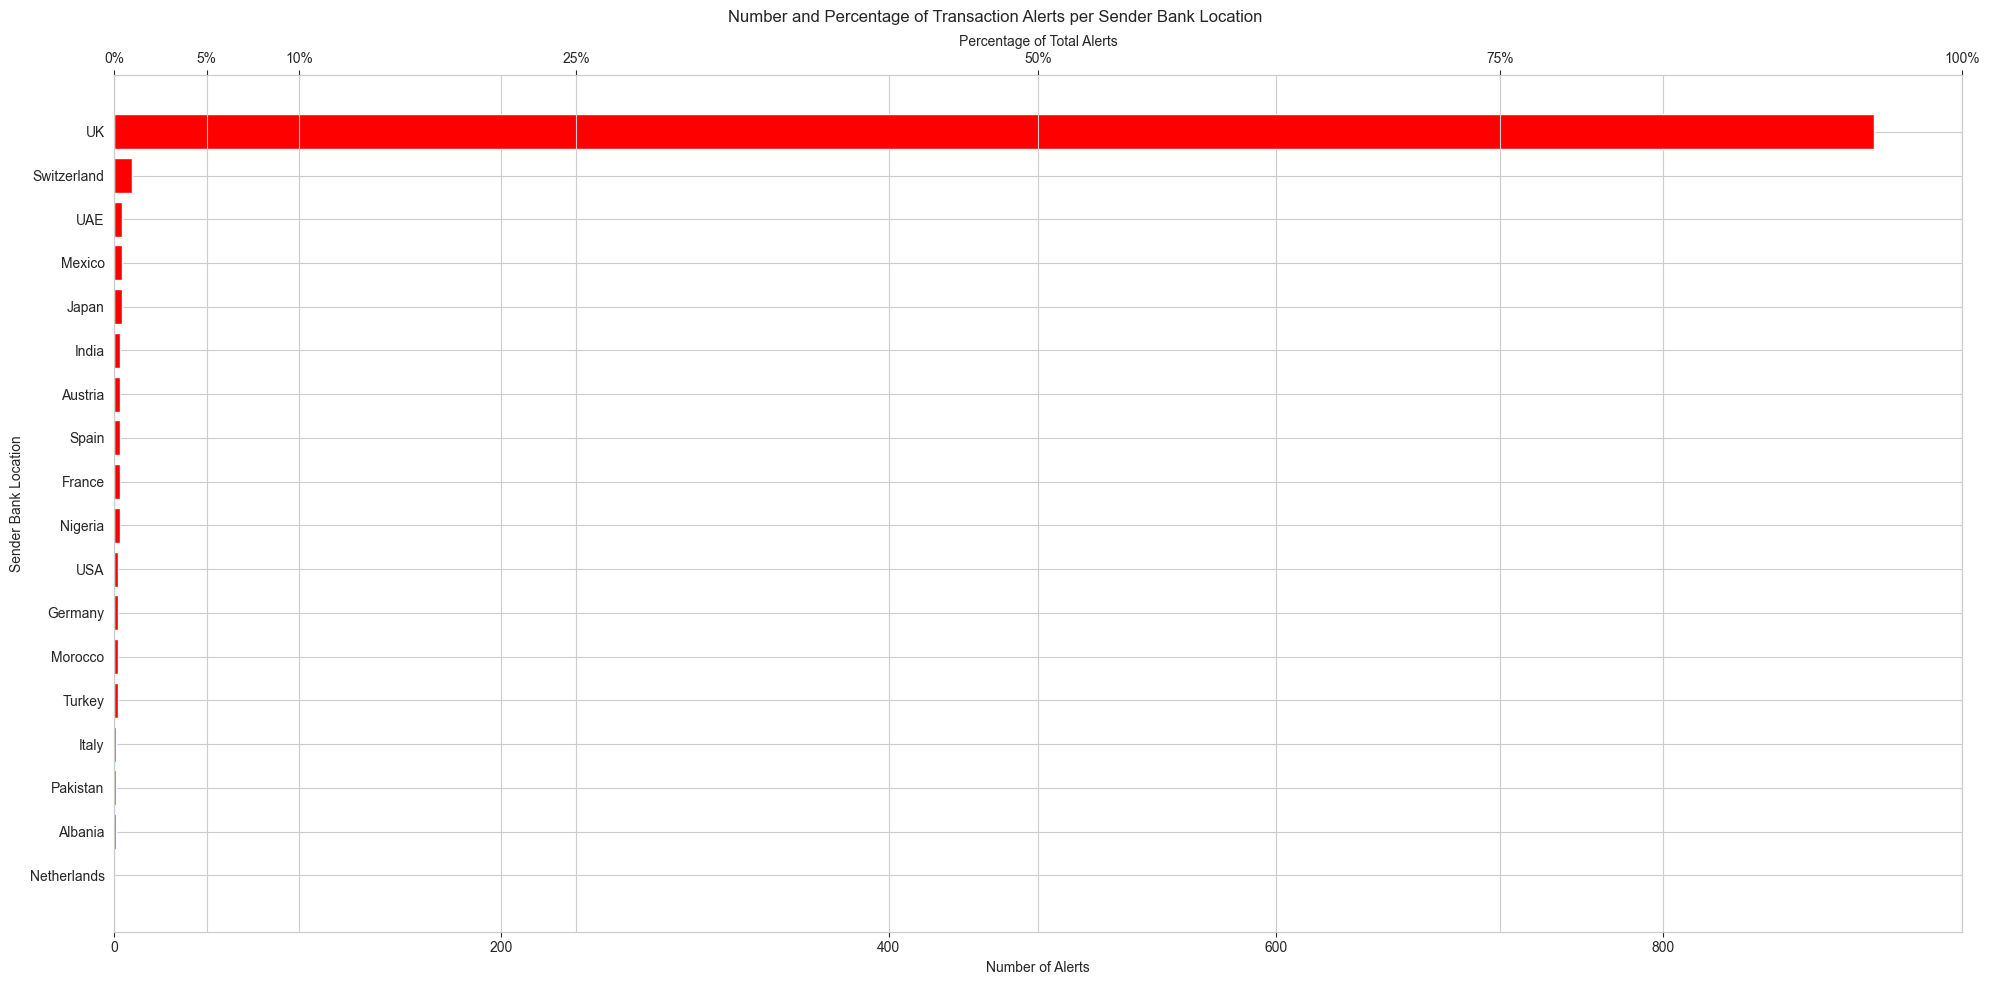

In [46]:
import matplotlib.pyplot as plt

# Prepare data
alerts_per_location = df.groupby('Sender_bank_location')['Is_laundering'].sum().reset_index()
alerts_per_location = alerts_per_location.sort_values('Is_laundering', ascending=True)

total_alerts = alerts_per_location['Is_laundering'].sum()
alerts_per_location['Percentage'] = (alerts_per_location['Is_laundering'] / total_alerts) * 100

# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twiny()

# Plot horizontal bar chart on primary axis (number of alerts)
bars = ax1.barh(
    alerts_per_location['Sender_bank_location'], 
    alerts_per_location['Is_laundering'], 
    color='red'
)

# Set axis labels and title
ax1.set_xlabel("Number of Alerts")
ax2.set_xlabel("Percentage of Total Alerts")
ax1.set_ylabel("Sender Bank Location")
fig.suptitle("Number and Percentage of Transaction Alerts per Sender Bank Location")

# Set ticks for secondary axis (percentage)
def convert_to_percentage(x):
    return (x / total_alerts) * 100

def convert_to_count(p):
    return (p / 100) * total_alerts

ax2.set_xlim(convert_to_percentage(ax1.get_xlim()[0]), convert_to_percentage(ax1.get_xlim()[1]))
ax2.set_xticks([0, 5, 10, 25, 50, 75, 100])
ax2.set_xticklabels([f"{x:.0f}%" for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()


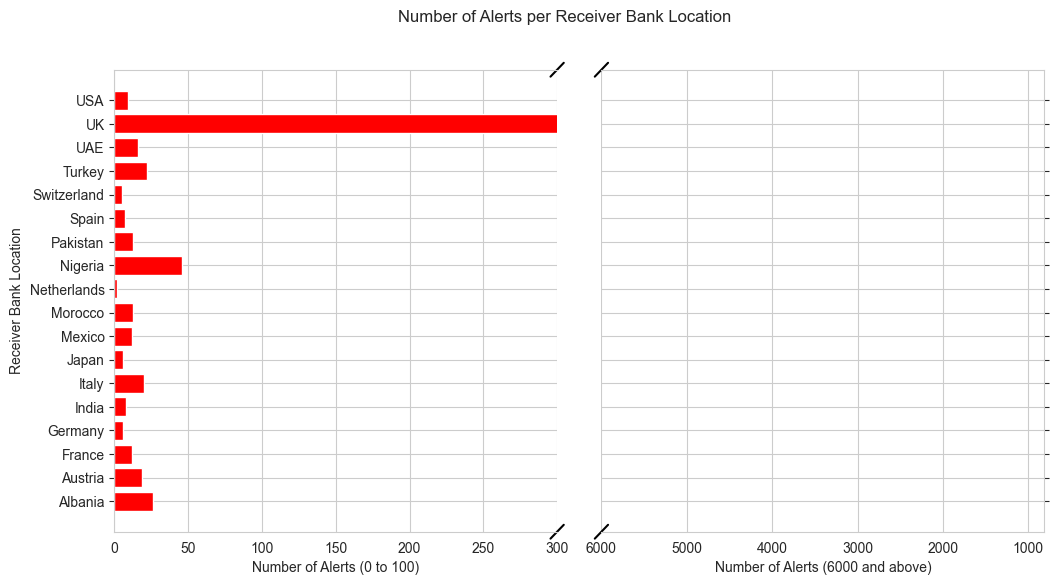

In [47]:
alerts_per_location = df.groupby('Receiver_bank_location')['Is_laundering'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)  # Adjust the spacing between subplots

ax1.barh(alerts_per_location['Receiver_bank_location'], alerts_per_location['Is_laundering'], color='red')
ax2.barh(alerts_per_location['Receiver_bank_location'], alerts_per_location['Is_laundering'], color='red')

ax1.set_xlim(0, 300)  # Set the left subplot values
ax2.set_xlim(6000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values

fig.suptitle('Number of Alerts per Receiver Bank Location')

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])

d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (6000 and above)')
ax1.set_ylabel('Receiver Bank Location')

ax1.set_yticks(range(len(alerts_per_location['Receiver_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Receiver_bank_location'])

plt.show()

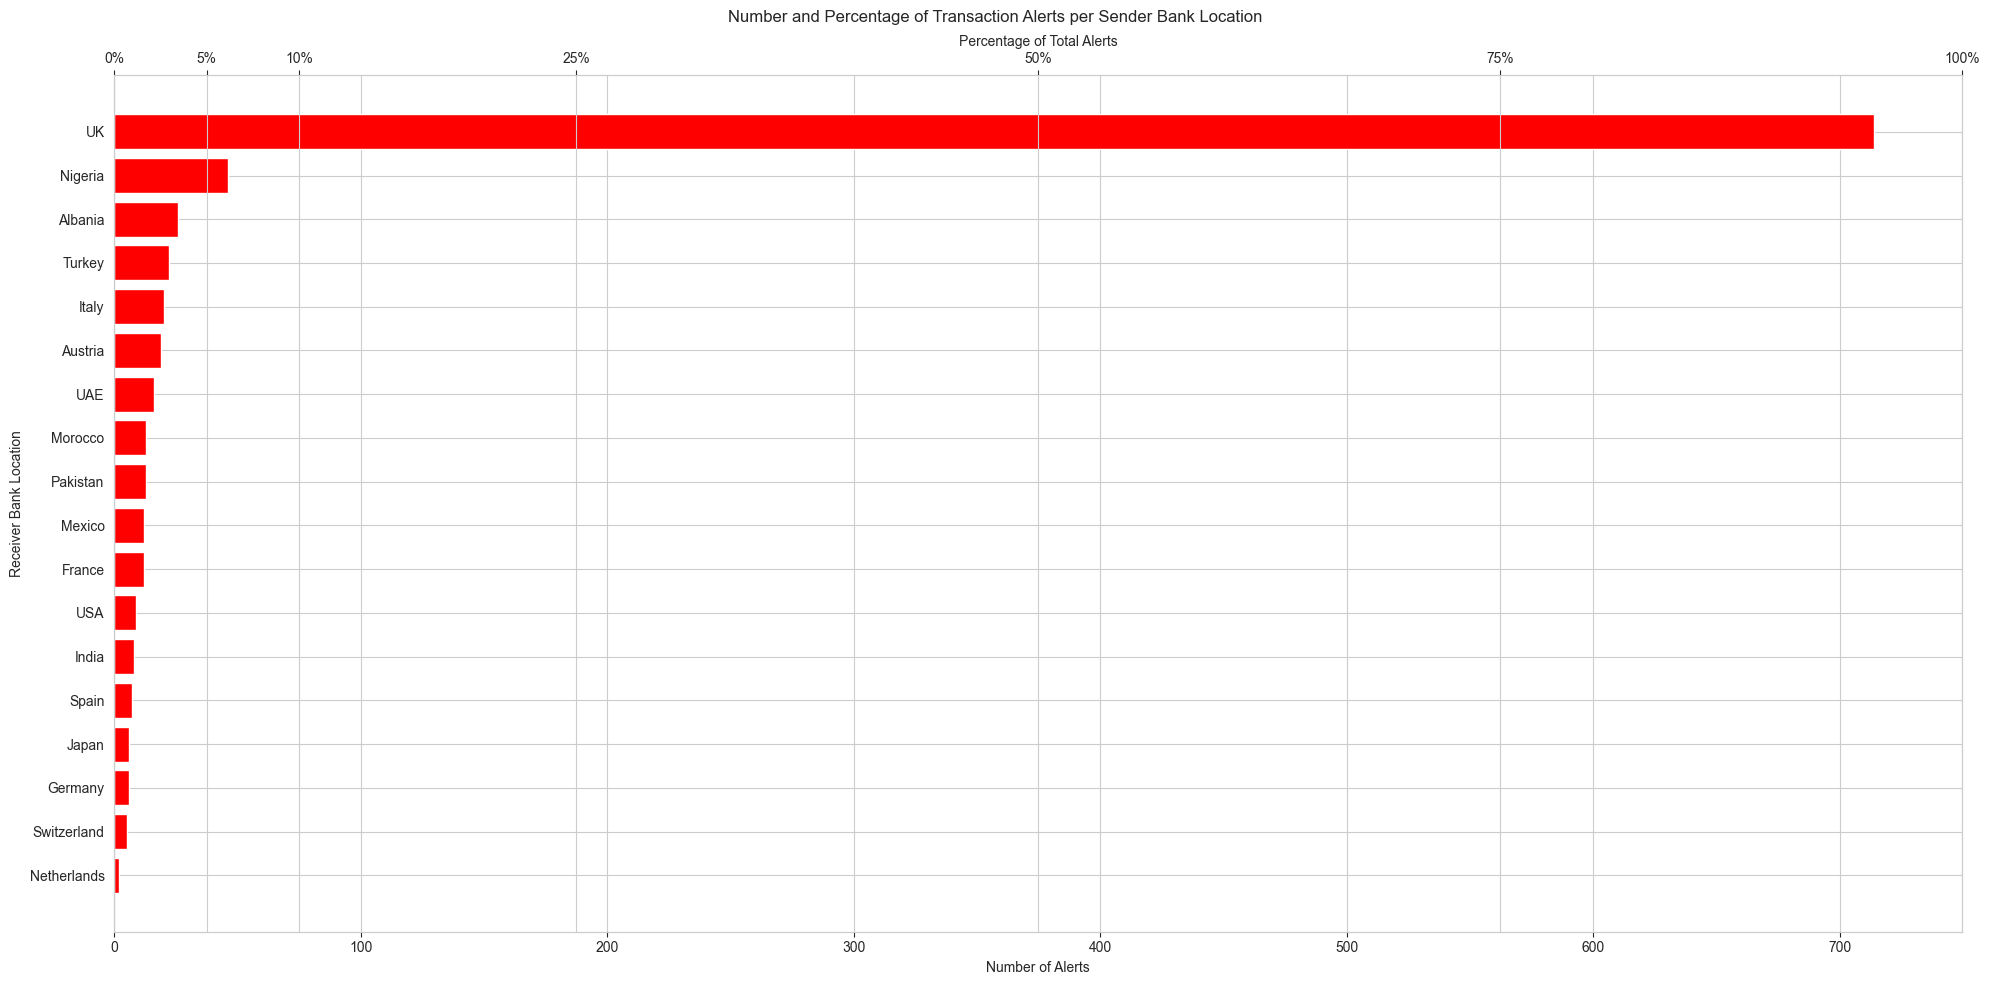

In [48]:
import matplotlib.pyplot as plt

# Prepare data
alerts_per_location = df.groupby('Receiver_bank_location')['Is_laundering'].sum().reset_index()
alerts_per_location = alerts_per_location.sort_values('Is_laundering', ascending=True)

total_alerts = alerts_per_location['Is_laundering'].sum()
alerts_per_location['Percentage'] = (alerts_per_location['Is_laundering'] / total_alerts) * 100

# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twiny()

# Plot horizontal bar chart on primary axis (number of alerts)
bars = ax1.barh(
    alerts_per_location['Receiver_bank_location'], 
    alerts_per_location['Is_laundering'], 
    color='red'
)

# Set axis labels and title
ax1.set_xlabel("Number of Alerts")
ax2.set_xlabel("Percentage of Total Alerts")
ax1.set_ylabel("Receiver Bank Location")
fig.suptitle("Number and Percentage of Transaction Alerts per Sender Bank Location")

# Set ticks for secondary axis (percentage)
def convert_to_percentage(x):
    return (x / total_alerts) * 100

def convert_to_count(p):
    return (p / 100) * total_alerts

ax2.set_xlim(convert_to_percentage(ax1.get_xlim()[0]), convert_to_percentage(ax1.get_xlim()[1]))
ax2.set_xticks([0, 5, 10, 25, 50, 75, 100])
ax2.set_xticklabels([f"{x:.0f}%" for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()


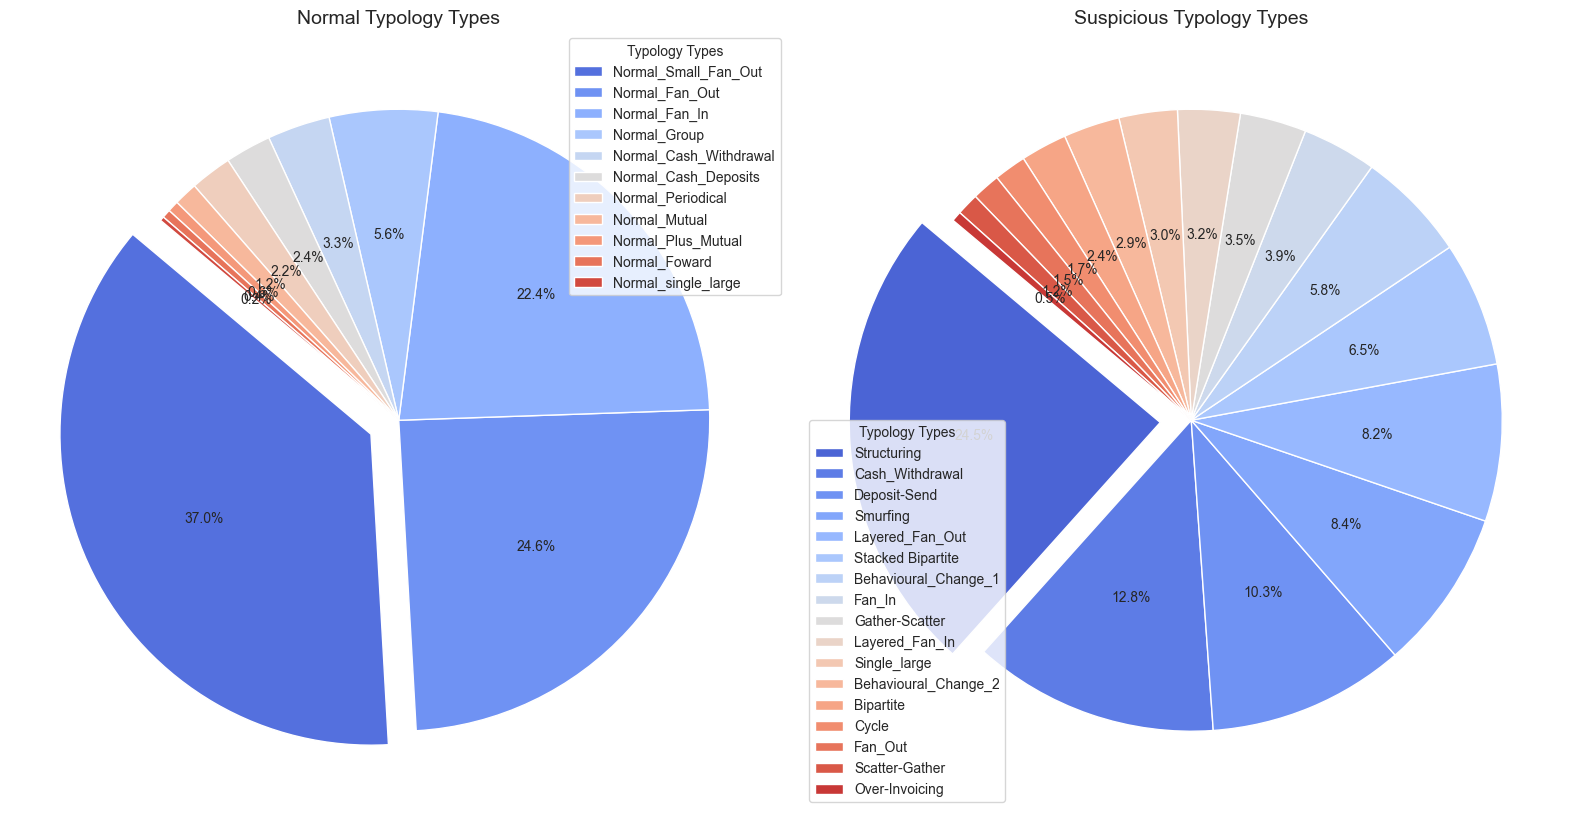

In [49]:
normal_data = df[df['Is_laundering'] == 0]['Laundering_type'].value_counts()
laundering_data = df[df['Is_laundering'] == 1]['Laundering_type'].value_counts()

# palette_normal = sns.color_palette("husl", len(normal_data))
palette_normal = sns.color_palette("coolwarm", len(normal_data))
palette_laundering = sns.color_palette("coolwarm", len(laundering_data))

fig, axs = plt.subplots(1, 2, figsize=(16, 10))

explode_normal = [0.1] + [0] * (len(normal_data) - 1)
explode_laundering = [0.1] + [0] * (len(laundering_data) - 1)

patches, texts, autotexts = axs[0].pie(normal_data, explode=explode_normal, autopct='%1.1f%%', colors=palette_normal, startangle=140)
axs[0].set_title('Normal Typology Types', fontsize=14)
axs[0].legend(patches, normal_data.index, loc='best', title="Typology Types", fontsize=10)

patches, texts, autotexts = axs[1].pie(laundering_data, explode=explode_laundering, autopct='%1.1f%%', colors=palette_laundering, startangle=140)
axs[1].set_title('Suspicious Typology Types', fontsize=14)
axs[1].legend(patches, laundering_data.index, loc='best', title="Typology Types", fontsize=10)

for text in texts + autotexts:
  text.set_fontsize(10)

plt.tight_layout()
plt.show()